분류 성능비교
==

다루는 내용
--
- 분류 알고리즘 비교
- 교차검증
- 정적 성능평가 Confusion matrix  
- 동적 성능평가 ROC

데이터
--
- 포도주 품질 분류 https://goo.gl/Gyc8K7

출처
--
https://www.kaggle.com/vishalyo990/prediction-of-quality-of-wine/notebook



모듈 불러오기
--

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

데이터 읽기 (포도주 품질 평가)
--

In [2]:
wine = pd.read_csv('data/winequality-red.csv')
# 데이터 사본 https://goo.gl/m3eCrf

In [3]:
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine.shape

(1599, 12)

- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [5]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## 여러 특성 한번에 보기 (박스 플롯)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Text xticklabel objects>)

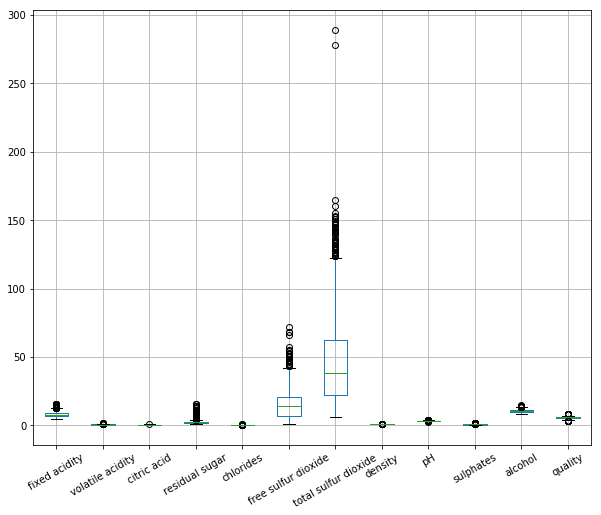

In [7]:
wine.boxplot(figsize = (10,8))
plt.xticks(rotation=30)

줄여서 보기
--

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Text xticklabel objects>)

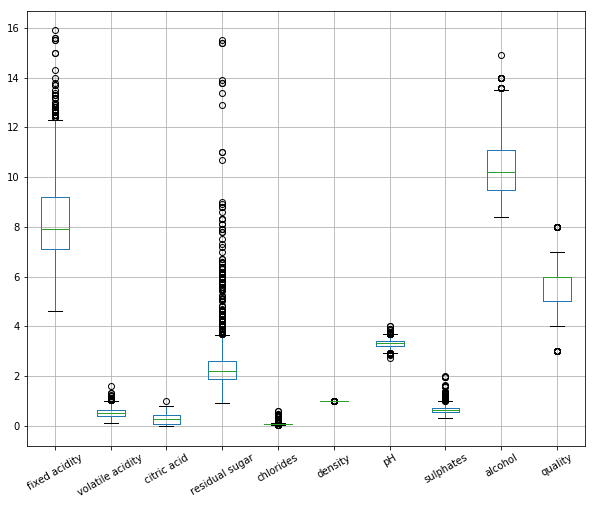

In [8]:
wine.drop(['free sulfur dioxide', 'total sulfur dioxide'], axis=1).boxplot(figsize = (10,8))
plt.xticks(rotation=30)

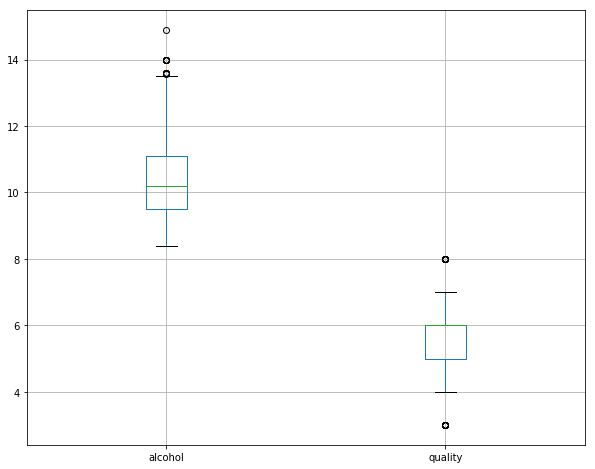

In [9]:
wine[['alcohol', 'quality']].boxplot(figsize = (10,8))

히스토그램
--

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a09ce1ac8>,
      dtype=object)

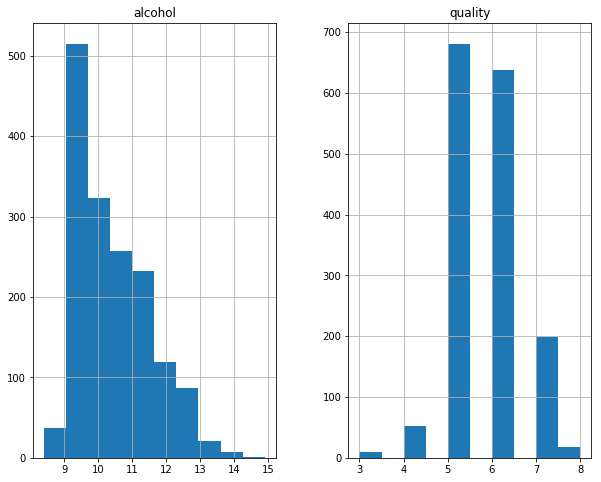

In [10]:
wine[['alcohol', 'quality']].hist(figsize = (10,8))

In [11]:
wine[['alcohol', 'quality']].head(10)

,alcohol,quality
0,9.4,5
1,9.8,5
2,9.8,5
3,9.8,6
4,9.4,5
5,9.4,5
6,9.4,5
7,10.0,7
8,9.5,7
9,10.5,5


품질관련 데이터 파악
--

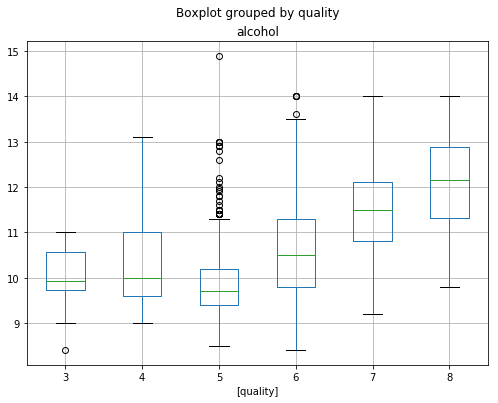

In [12]:
wine[['alcohol', 'quality']].boxplot(by='quality',figsize = (8,6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a0a3e9518>,
      dtype=object)

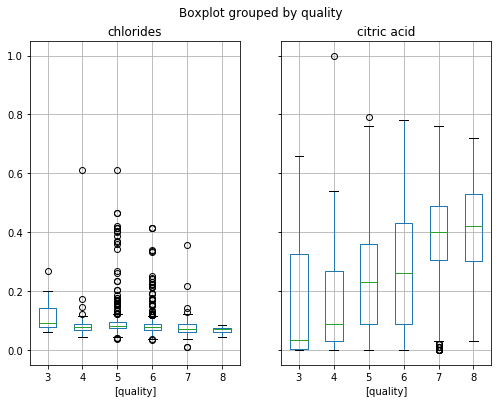

In [13]:
wine1 = wine[[ 'chlorides', 'citric acid', 'quality']]
wine1.boxplot(by='quality',figsize = (8,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0a65ce10>,
      dtype=object)

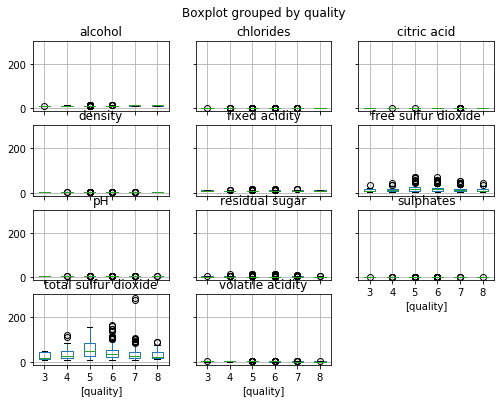

In [14]:
wine.boxplot(by='quality',figsize = (8,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0b02e080>,
      dtype=object)

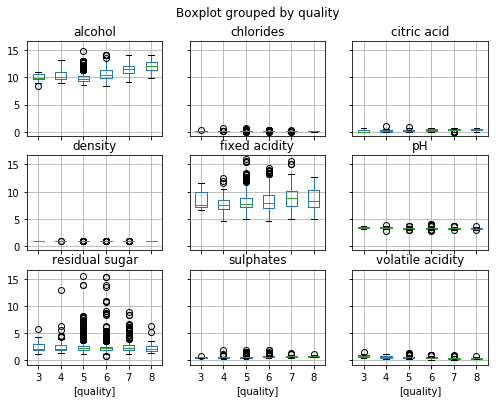

In [15]:
wine.drop(['free sulfur dioxide', 'total sulfur dioxide'], axis=1).boxplot(by='quality',figsize = (8,6))

## 데이터 전처리 (레이블 만들기)

In [16]:
wine['quality'].unique() 

array([5, 6, 7, 4, 8, 3])

In [17]:
wine.quality.unique() 

array([5, 6, 7, 4, 8, 3])

In [18]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [19]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
bins = (2.9, 6.5, 8.1)
group_names = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = bins, labels = group_names) 

In [20]:
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,qual
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [21]:
wine['qual'].value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [22]:
# 예측변수와 레이블을 나눈다
# X 데이터에서는 'quality'와 'qual' 컬럼 제거
# y는 레이블만 담는다

X_new = wine.drop(['quality', 'qual'], axis = 1) 
y = wine['qual'] 

In [23]:
X_new.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [24]:
y.value_counts()

0    1382
1     217
Name: qual, dtype: int64

표준 스케일링
--

전체 자료의 분포를 평균 0, 분산 1이 되도록 만든다.  
X에는 수치 데이터만 들어야 한다.  
테스트 데이터도 같이 스케일링하는 것을 잊지 않는다

In [25]:
sc = StandardScaler()
X = sc.fit_transform(X_new)

In [26]:
# 데이터 프레임에 스케일링 연산을 하면 ndarray로 바뀐다
X[:5]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711],
       [ 1.65485608, -1.38444349,  1.4841536 , -0.45321841, -0.26496041,
         0.10759209,  0.41150046,  0.6642772 , -0.97910442, -0.46118037,
        -0.58477711],
       [-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [27]:
# 데이터를 랜덤하게 섞은 후 80%를 훈련데이터로 사용
# random_state 같은 값으로 지정하면 랜덤하게 섞이는 순서가 같다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

In [28]:
X_train.shape, y_train.shape

((1279, 11), (1279,))

In [29]:
X_test.shape, y_test.shape

((320, 11), (320,))

## 선형 모델(확률적 경사 하강법 사용)

In [30]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd.score(X_test,y_test)

/Users/hwa-jongkim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.859375

결정 트리 (Decesion Tree)
--

In [31]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.853125

## 랜덤 포래스트 (Random Forest Classifier)

In [32]:
rfc = RandomForestClassifier(n_estimators=300) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.9125

##  정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [33]:
pred_rfc = rfc.predict(X_test)
confusion_matrix(y_test, pred_rfc)
# RandomForest에 대한 confusion_matrix

array([[269,  10],
       [ 18,  23]])

아래는 모델이 올바르게 예측했는지를 평가하기 위한 값들이다

In [34]:
# 여러 성능 지표를 출력한다
print(classification_report(y_test, pred_rfc))

             precision    recall  f1-score   support

          0       0.94      0.96      0.95       279
          1       0.70      0.56      0.62        41

avg / total       0.91      0.91      0.91       320



- Precision  = 모델이 옳다고 한 것이 실제로 옳은 비율     TP / ( TP + FP ) 
- Recall =  실제 정답인 것들 중, 모델이 정답이라고 예측한 것    TP / TP+FN
- f1-score = Precision과 Recall의 조화평균  (2 x  Precision x Recall ) /  (Precision + Recall)
- support는 이 모델에서 응답한 샘플의 수이다

## Support Vector Classifier (SVC)

In [35]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.8875

Logistic Regression
--

In [36]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

0.88125

## Cross validation(교차 검증)

In [37]:
# estimator = 모델, cv는 분할 테스트 숫자
rfc_eval = cross_val_score(rfc, X = X, y = y, cv = 5)  
rfc_eval  # 5번의 교차 검증 결과를 보여준다

array([0.87850467, 0.85046729, 0.87147335, 0.86833856, 0.88714734])

In [38]:
rfc_eval.mean()

0.871186242053145

Percentile Test
==

상위 30% 중요 특성만 사용한 경우
--

In [39]:
#  영향력이 큰 상위 특성들을 선택한다

from sklearn import feature_selection
from sklearn.feature_selection import SelectPercentile
fs = SelectPercentile(feature_selection.chi2, percentile = 30)
X_new_Percentile = fs.fit_transform(X_new, y)

In [40]:
fs.get_support()

array([False, False, False, False, False,  True,  True, False, False,
       False,  True])

In [41]:
X_new.columns[fs.get_support()]

Index(['free sulfur dioxide', 'total sulfur dioxide', 'alcohol'], dtype='object')

In [42]:
fs.scores_

array([8.39309647e+00, 7.11376886e+00, 1.03170774e+01, 2.85636942e+00,
       3.83204308e-01, 5.66960318e+01, 7.24343506e+02, 1.29279528e-04,
       3.77466070e-02, 2.77619023e+00, 2.88860888e+01])

In [43]:
X_new_Percentile

array([[11. , 34. ,  9.4],
       [25. , 67. ,  9.8],
       [15. , 54. ,  9.8],
       ...,
       [29. , 40. , 11. ],
       [32. , 44. , 10.2],
       [18. , 42. , 11. ]])

In [44]:
rfc = RandomForestClassifier(n_estimators=300) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.903125

분류 성능 평가 (정적)
--

In [45]:
from itertools import cycle
from sklearn import svm, datasets
import sklearn.metrics 
from sklearn.preprocessing import label_binarize
from scipy import interp

In [46]:
X.shape, y.shape

((1599, 11), (1599,))

소량의 데이터 사용
--

In [47]:
rand =29
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=rand)
X_train.shape, y_train.shape

((1279, 11), (1279,))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=rand)
X_train.shape, y_train.shape

((1023, 11), (1023,))

In [49]:
X_test.shape, y_test.shape

((256, 11), (256,))

Score (맞다고 생각하는 점수)
--

선형모델
--

In [50]:
classifier = SGDClassifier()
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
y_score

/Users/hwa-jongkim/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([-1.35177038e+01, -1.01531443e+01, -6.07955099e+00, -9.96381799e+00,
       -2.37868713e+01, -1.83042060e+01, -3.23010339e+01,  4.99162562e+00,
       -2.98362038e+01, -4.74466988e+01, -2.01570463e+01, -4.40741012e+01,
       -1.32037568e+01, -9.08427189e+00, -7.22376843e+00,  7.48350794e+00,
       -3.14749511e+01, -2.91454502e+01, -3.85142714e+00, -2.50434181e+01,
       -4.22467608e+01, -1.23760608e+01, -1.73917251e+01, -1.08374430e+01,
       -3.14033115e+01, -1.33941841e+01, -1.07027495e+01, -4.25405187e+01,
       -3.64208285e+01, -1.27635560e+01, -1.10779170e+01, -3.92189392e+01,
       -1.05418393e+01, -4.10729881e+01, -1.44932670e+01, -2.10380684e+01,
       -5.45675888e+01, -9.03826792e+00, -1.28677193e+01, -2.91454502e+01,
       -4.63023339e+01, -1.78939815e+01, -1.58049133e+01, -1.99117997e+01,
        3.38323162e+00,  5.61611255e+00, -2.00506675e+01,  3.18279924e-01,
       -3.33356507e+01, -8.02772239e+00, -3.39391449e+01, -9.56310608e+00,
       -3.34867577e+01,  

svc (참고)
--

In [51]:
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=rand))
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# y_score

컨퓨전 매트릭스 (적절한 threshold를 택함)
--

In [52]:
y_predict = classifier.predict(X_test)
confusion_matrix(y_test, y_predict)

array([[196,  21],
       [ 24,  15]])

In [53]:
classifier.score(X_test,y_test)   # =  27/32

0.82421875

랭킹 (순서를 평가)
--

In [54]:
result = pd.DataFrame(y_predict, columns=['predict'])
result['real'] = y_test.values
result['correct'] = result.predict ==result.real
result['score'] = y_score
result

,predict,real,correct,score
0,0,0,True,-13.517704
1,0,0,True,-10.153144
2,0,0,True,-6.079551
3,0,0,True,-9.963818
4,0,0,True,-23.786871
5,0,0,True,-18.304206
6,0,0,True,-32.301034
7,1,0,False,4.991626
8,0,0,True,-29.836204
9,0,1,False,-47.446699


In [55]:
r = result.sort_values(by='score', ascending=False)
r

,predict,real,correct,score
180,1,0,False,22.790193
117,1,1,True,18.886121
207,1,0,False,16.484626
111,1,1,True,15.923182
141,1,0,False,15.457781
206,1,0,False,13.684976
102,1,0,False,13.212382
171,1,0,False,12.733299
53,1,1,True,11.150333
242,1,0,False,10.650628


ROC로 성능 평가 (맞춘 순서를 평가)
--

In [56]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

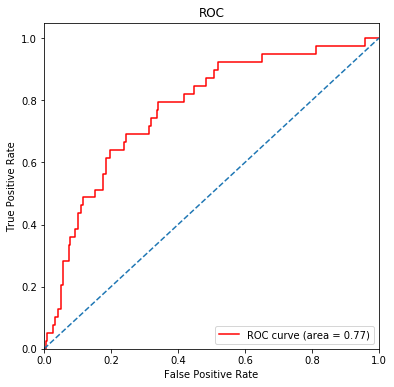

In [57]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='r', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")